#### Get total models and Dependency Tuples

In [1]:
import csv
from collections import Counter

prefix_counts = Counter()

with open('../../data/model_relation/batch_all_0625.csv', 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        prefix = row.get('Type', 'N/A').lower() 
        if prefix == 'adapter':
            prefix = 'finetune'
        prefix_counts[prefix] += 1

total = sum(prefix_counts.values())
print(f"Total models: {total}")

for prefix, count in prefix_counts.items():
    percentage = (count / total) * 100
    print(f"{prefix}: {count} ({percentage:.2f}%)")

selected_types = ['finetune', 'quantized', 'merge']
selected_total = sum(prefix_counts.get(t, 0) for t in selected_types)
selected_percentage = (selected_total / total) * 100

print(f"\ndependency tuples : {selected_total} ({selected_percentage:.2f}%)")

Total models: 1817398
finetune: 427475 (23.52%)
n/a: 1276560 (70.24%)
quantized: 100564 (5.53%)
merge: 12799 (0.70%)

dependency tuples : 540838 (29.76%)


#### Download Statistics by Model Type

In [3]:
import pandas as pd

degree_df = pd.read_csv("../../data/model_degree_0625.csv")
props_df = pd.read_csv("../../data/model_props_0625.csv")
props_df["Download"] = pd.to_numeric(props_df["Download"], errors="coerce").fillna(0).astype(int)
merged_df = pd.merge(degree_df, props_df, on="Model ID", how="left")

merged_df["Download"] = merged_df["Download"].fillna(0).astype(int)


derived_models = merged_df[merged_df["In-degree"] > 0]
base_models = merged_df[merged_df["Out-degree"] > 0]
isolated_models = merged_df[(merged_df["In-degree"] == 0) & (merged_df["Out-degree"] == 0)]
relational_models = merged_df[(merged_df["In-degree"] > 0) | (merged_df["Out-degree"] > 0)]
total_models = merged_df

def print_download_stats(name, df):
    total_dl = df["Download"].sum()
    count = len(df)
    avg_dl = total_dl / count if count > 0 else 0
    print(f"{name}: {count:,} models, total downloads = {total_dl:,}, average downloads = {avg_dl:,.2f}")

# result
print("=== Download Statistics by Model Type ===")
print_download_stats("Derived models: ", derived_models)
print_download_stats("Base models: ", base_models)
print_download_stats("Isolated models: ", isolated_models)
print_download_stats("Relational models: ", relational_models)
print_download_stats("All models", total_models)

=== Download Statistics by Model Type ===
Derived models: : 540,838 models, total downloads = 268,887,576, average downloads = 497.17
Base models: : 49,648 models, total downloads = 1,412,664,976, average downloads = 28,453.61
Isolated models: : 1,251,376 models, total downloads = 249,757,419, average downloads = 199.59
Relational models: : 566,022 models, total downloads = 1,475,955,546, average downloads = 2,607.59
All models: 1,817,398 models, total downloads = 1,725,712,965, average downloads = 949.55


#### Distribution of Derived Models

In [4]:
import csv
from collections import Counter

prefix_counts = Counter()

with open('../../data/model_relation/batch_all_0625.csv', 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        prefix = row.get('Type', 'N/A').lower()  
        if prefix == 'adapter':
            prefix = 'finetune'
        prefix_counts[prefix] += 1

total = sum(prefix_counts.values())
print(f"Total models: {total}")


selected_types = ['finetune', 'quantized', 'merge']
selected_total = sum(prefix_counts.get(t, 0) for t in selected_types)
selected_percentage = (selected_total / total) * 100

print(f"derived models : {selected_total} ({selected_percentage:.2f}%)")

for prefix, count in prefix_counts.items():
    percentage = (count / selected_total) * 100
    print(f"{prefix}: {count} ({percentage:.2f}%)")


Total models: 1817398
derived models : 540838 (29.76%)
finetune: 427475 (79.04%)
n/a: 1276560 (236.03%)
quantized: 100564 (18.59%)
merge: 12799 (2.37%)


#### Task Distribution of M_f M_m M_q

In [5]:
import pandas as pd

df_dep = pd.read_csv('../../data/model_relation/batch_all_0625.csv')
df_props = pd.read_csv('../../data/model_props_0625.csv')

df_dep = df_dep.rename(columns={'Model ID': 'Model_ID', 'Type': 'Dependency_Type'})
df_props = df_props.rename(columns={'Model ID': 'Model_ID', 'Download': 'Downloads', 'Model Category': 'Model_Category'})

df_dep['Dependency_Type'] = df_dep['Dependency_Type'].replace('adapter', 'finetune')

df_merged = pd.merge(df_dep, df_props, on='Model_ID', how='left')

df_valid = df_merged[df_merged['Dependency_Type'].notna() & (df_merged['Dependency_Type'] != 'N/A')]

df_valid_cat = df_valid[df_valid['Model_Category'].notna() & (df_valid['Model_Category'].str.lower() != 'unknown')]
cat_dist = df_valid_cat.groupby(['Dependency_Type', 'Model_Category']).size().unstack().fillna(0).astype(int)

row_totals = cat_dist.sum(axis=1)
cat_dist["Total"] = row_totals

cat_dist_percent = cat_dist.div(row_totals, axis=0) * 100  
cat_dist_str = cat_dist.copy()

for row in cat_dist.index:
    for col in cat_dist.columns:
        count = cat_dist.loc[row, col]
        perc = cat_dist_percent.loc[row, col]
        cat_dist_str.loc[row, col] = f"{int(count):,} ({perc:.1f}%)"

print(cat_dist_str)

Model_Category           Audio              CV    Multimodal              NLP  \
Dependency_Type                                                                 
finetune         12,804 (6.8%)  63,721 (33.6%)  3,208 (1.7%)  109,591 (57.8%)   
merge                 7 (0.1%)      551 (4.7%)    152 (1.3%)   11,092 (94.0%)   
quantized           348 (1.0%)      687 (2.0%)  1,209 (3.5%)   31,855 (93.3%)   

Model_Category  Reinforcement Learning    Tabular             Total  
Dependency_Type                                                      
finetune                    104 (0.1%)  23 (0.0%)  189,451 (100.0%)  
merge                         1 (0.0%)   0 (0.0%)   11,803 (100.0%)  
quantized                    53 (0.2%)   5 (0.0%)   34,157 (100.0%)  


#### Top-10 models by out-degree and in-degree

In [6]:
import pandas as pd

df = pd.read_csv("../../data/model_degree_0625.csv")
df_props = pd.read_csv("../../data/model_props_0625.csv")

top_in_degree = df.sort_values("In-degree", ascending=False).head(10)
top_out_degree = df.sort_values("Out-degree", ascending=False).head(10)

top_in_with_task = pd.merge(top_in_degree, df_props[["Model ID", "Task"]], on="Model ID", how="left")
top_out_with_task = pd.merge(top_out_degree, df_props[["Model ID", "Task"]], on="Model ID", how="left")

print("\nTop 10 Models by Out-degree (with Task):")
print(top_out_with_task[["Model ID", "Out-degree", "Task"]])

print("Top 10 Models by In-degree (with Task):")
print(top_in_with_task[["Model ID", "In-degree", "Task"]])


Top 10 Models by Out-degree (with Task):
                                   Model ID  Out-degree             Task
0                         Qwen/Qwen1.5-0.5B       32497  text-generation
1              black-forest-labs/FLUX.1-dev       32173    text-to-image
2                         Qwen/Qwen1.5-1.8B       30580  text-generation
3                           google/gemma-2b       23792  text-generation
4                           google/gemma-7b        9569  text-generation
5        distilbert/distilbert-base-uncased        9205        fill-mask
6  stabilityai/stable-diffusion-xl-base-1.0        8266    text-to-image
7                           Qwen/Qwen1.5-7B        6450  text-generation
8             google-bert/bert-base-uncased        5483        fill-mask
9           aubmindlab/bert-base-arabertv02        3997        fill-mask
Top 10 Models by In-degree (with Task):
                                            Model ID  In-degree  \
0                   Novaciano/BAHAMUTH-PURGED-3.

#### The num of model chains

In [7]:
import csv

input_file = "../../data/model_depth_0625.txt"
output_csv = "../../data/model_depth_0625.csv"

model_depth_list = []
total_chain_count = 0 

with open(input_file, "r", encoding="utf-8") as f:
    lines = f.readlines()

current_model = None
current_depth = None

for line in lines:
    if line.startswith("Root Model:"):
        current_model = line.strip().split("Root Model:")[1].strip()
    elif line.startswith("Max Depth:") and current_model:
        current_depth = int(line.strip().split("Max Depth:")[1].strip()) + 1
    elif line.startswith("Total Chains from Root:") and current_model and current_depth is not None:
        chain_count = int(line.strip().split("Total Chains from Root:")[1].strip())
        total_chain_count += chain_count
        model_depth_list.append((current_model, current_depth, chain_count))
        current_model = None
        current_depth = None

with open(output_csv, "w", newline='', encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["model_id", "depth", "total_chains"])
    writer.writerows(model_depth_list)

print(f"The detailed info of model chains is saved to {output_csv}")
print(f"The num of model chains is {total_chain_count}")

The detailed info of model chains is saved to ../../data/model_depth_0625.csv
The num of model chains is 1008871


#### The distribution of the length of model chains

Matplotlib created a temporary cache directory at /tmp/matplotlib-_hhu3nyz because the default path (/home/dellr740/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


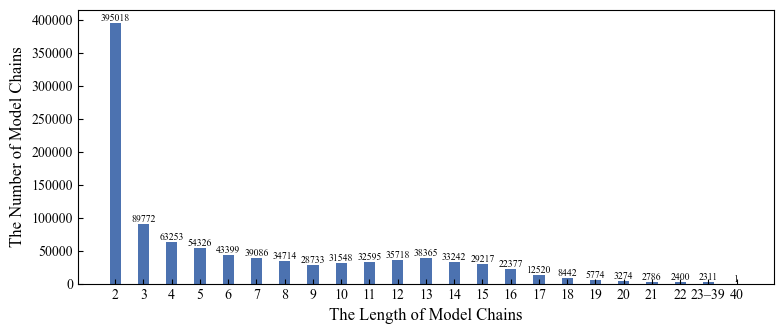

In [1]:
import matplotlib.pyplot as plt
from collections import Counter

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "mathtext.fontset": "stix",
    "font.size": 12,
    "figure.figsize": (8, 3.5),
    "lines.linewidth": 1,
    "lines.markersize": 4,
    "axes.linewidth": 0.8,
    "axes.titlesize": 10,
    "axes.labelsize": 12,
    "axes.grid": False,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": False,
    "ytick.right": False,
    "legend.fontsize": 12,
    "legend.frameon": False,
    "savefig.dpi": 3600,
    "savefig.bbox": "tight"
})

file_path = "../../data/model_chain_lengths_0625.txt"
with open(file_path, "r", encoding="utf-8") as f:
    lengths = [int(line.strip()) for line in f if line.strip().isdigit()]

length_counts = Counter(lengths)

merged_counts = {}

for length, count in length_counts.items():
    if 2 <= length <= 22:
        merged_counts[str(length)] = count
    elif 23 <= length <= 39:
        merged_counts["23–39"] = merged_counts.get("23–39", 0) + count
    elif length == 40:
        merged_counts["40"] = count

labels = list(range(2, 23)) + ["23–39", "40"]
labels = [str(l) for l in labels]
frequencies = [merged_counts[l] for l in labels]

spacing = 2
x_positions = [i * spacing for i in range(len(labels))]

plt.figure()
bar_width = 0.8
bars = plt.bar(x_positions, frequencies, width=bar_width, color='#4C72B0')

for x, y in zip(x_positions, frequencies):
    plt.text(x, y + 10, str(y), ha='center', va='bottom', fontsize=7)

plt.xticks(ticks=x_positions, labels=labels)

plt.xlabel("The Length of Model Chains")
plt.ylabel("The Number of Model Chains")
plt.tight_layout()

plt.savefig("chain_length_distribution.png")

#### The dominant relation of model chains

In [1]:
import csv
from collections import Counter
import os

chain_file = "../../data/model_chains_0625.txt"
type_file = "../../data/batch_all_0625.csv"
output_chain_type = "../../output/chain_type_ratio.csv"
output_dominant_summary = "../../output/chain_dominant_summary.txt"

os.makedirs(os.path.dirname(output_chain_type), exist_ok=True)
os.makedirs(os.path.dirname(output_dominant_summary), exist_ok=True)

model_type_dict = {}
with open(type_file, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        model_id = row["Model ID"].strip()
        if not model_id:
            continue
        model_type = row["Type"].strip().lower()
        if model_type == "adapter":
            model_type = "finetune"
        model_type_dict[model_id] = model_type if model_type in {"finetune", "merge", "quantized"} else "N/A"

chain_stats = []
dominant_counter = Counter()

with open(chain_file, "r", encoding="utf-8") as f:
    for line_num, line in enumerate(f, start=1):
        if "->" not in line:
            continue
        try:
            models = [x.strip() for x in line.strip().split("->")]
            root = models[0]
            sub_models = models[1:] 
            type_counts = Counter()

            for m in sub_models:
                t = model_type_dict.get(m, "N/A")
                type_counts[t] += 1

            total = len(sub_models)
            ft = type_counts["finetune"]
            mg = type_counts["merge"]
            qt = type_counts["quantized"]
            na = type_counts["N/A"]

            ft_r = round(ft / total, 4) if total else 0
            mg_r = round(mg / total, 4) if total else 0
            qt_r = round(qt / total, 4) if total else 0
            na_r = round(na / total, 4) if total else 0

            dominant_types = [k for k, v in type_counts.items() if v == max(type_counts.values())]
            dominant = dominant_types[0] if dominant_types else "N/A"
            dominant_counter[dominant] += 1

            chain_stats.append([root, total, ft, mg, qt, na, ft_r, mg_r, qt_r, na_r, dominant])

        except Exception as e:
            print(f"[Line {line_num}] failed: {line.strip()}, error: {e}")

with open(output_chain_type, "w", encoding="utf-8", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Root Model", "Total", "finetune", "merge", "quantized", "N/A",
                     "finetune_ratio", "merge_ratio", "quantized_ratio", "N/A_ratio", "Dominant Type"])
    for row in chain_stats:
        writer.writerow(row)

with open(output_dominant_summary, "w", encoding="utf-8") as f:
    total_chains = sum(dominant_counter.values())
    print(f"Total chains: {total_chains}\n\n")
    for t in ["finetune", "merge", "quantized", "N/A"]:
        count = dominant_counter[t]
        percent = round(100 * count / total_chains, 2)
        f.write(f"{t}: {count} chains ({percent}%)\n")
        print(f"{t}: {count} chains ({percent}%)\n")

Total chains: 1008871


finetune: 458412 chains (45.44%)

merge: 489079 chains (48.48%)

quantized: 61380 chains (6.08%)

N/A: 0 chains (0.0%)



#### The diversity of model chains

In [8]:
import csv

input_file = "../../output/chain_type_ratio.csv"

single_dep = 0
double_dep = 0
triple_dep = 0
total_chains = 0

with open(input_file, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        ft = int(row["finetune"])
        mg = int(row["merge"])
        qt = int(row.get("quantize", row.get("quantized", 0))) 

        type_count = sum(1 for x in [ft, mg, qt] if int(x) > 0)
        total_chains += 1

        if type_count == 1:
            single_dep += 1
        elif type_count == 2:
            double_dep += 1
        elif type_count == 3:
            triple_dep += 1

print(f"Total Chains: {total_chains}")
print(f"Single-dependency chains : {single_dep} ({round(single_dep / total_chains * 100, 2)}%)")
print(f"Double-dependency chains : {double_dep} ({round(double_dep / total_chains * 100, 2)}%)")
print(f"Triple-dependency chains : {triple_dep} ({round(triple_dep / total_chains * 100, 2)}%)")

Total Chains: 1008871
Single-dependency chains : 462822 (45.88%)
Double-dependency chains : 263164 (26.08%)
Triple-dependency chains : 282885 (28.04%)


#### The relation in top-10 chains

In [29]:
import csv
from collections import Counter
import os

chain_file = "../../data/models_top_chains_0625.txt"
type_file = "../../data/batch_all_0625.csv"
output_chain_type = "../../output/chain_type_ratio_top.csv"
output_dominant_summary = "../../output/chain_dominant_summary_top.txt"

os.makedirs(os.path.dirname(output_chain_type), exist_ok=True)
os.makedirs(os.path.dirname(output_dominant_summary), exist_ok=True)

model_type_dict = {}
with open(type_file, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        model_id = row["Model ID"].strip()
        if not model_id:
            continue
        model_type = row["Type"].strip().lower()
        if model_type == "adapter":
            model_type = "finetune"
        model_type_dict[model_id] = model_type if model_type in {"finetune", "merge", "quantized"} else "N/A"

chain_stats = []
dominant_counter = Counter()

with open(chain_file, "r", encoding="utf-8") as f:
    for line_num, line in enumerate(f, start=1):
        if "->" not in line:
            continue
        try:
            models = [x.strip() for x in line.strip().split("->")]
            root = models[0]
            sub_models = models[1:] 
            type_counts = Counter()

            for m in sub_models:
                t = model_type_dict.get(m, "N/A")
                type_counts[t] += 1

            total = len(sub_models)
            ft = type_counts["finetune"]
            mg = type_counts["merge"]
            qt = type_counts["quantized"]
            na = type_counts["N/A"]

            ft_r = round(ft / total, 4) if total else 0
            mg_r = round(mg / total, 4) if total else 0
            qt_r = round(qt / total, 4) if total else 0
            na_r = round(na / total, 4) if total else 0

            dominant_types = [k for k, v in type_counts.items() if v == max(type_counts.values())]
            dominant = dominant_types[0] if dominant_types else "N/A"
            dominant_counter[dominant] += 1

            chain_stats.append([root, total, ft, mg, qt, na, ft_r, mg_r, qt_r, na_r, dominant])

        except Exception as e:
            print(f"[Line {line_num}] failed : {line.strip()},error: {e}")

with open(output_chain_type, "w", encoding="utf-8", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Root Model", "Total", "finetune", "merge", "quantized", "N/A",
                     "finetune_ratio", "merge_ratio", "quantized_ratio", "N/A_ratio", "Dominant Type"])
    for row in chain_stats:
        writer.writerow(row)

with open(output_dominant_summary, "w", encoding="utf-8") as f:
    total_chains = sum(dominant_counter.values())
    f.write(f"Total chains: {total_chains}\n\n")
    print(f"Total chains: {total_chains}\n\n")
    for t in ["finetune", "merge", "quantized", "N/A"]:
        count = dominant_counter[t]
        percent = round(100 * count / total_chains, 2)
        f.write(f"{t}: {count} chains ({percent}%)\n")
        print(f"{t}: {count} chains ({percent}%)\n")


Total chains: 10


finetune: 6 chains (60.0%)

merge: 4 chains (40.0%)

quantized: 0 chains (0.0%)

N/A: 0 chains (0.0%)



#### The task of models in top-10 chains

In [1]:
import pandas as pd

chain_file = "../../data/models_top_chains_0625.txt"
props_file = "../../data/model_props_0625.csv"

df_props = pd.read_csv(props_file)
model_to_category = dict(zip(df_props["Model ID"], df_props["Model Category"]))

all_models = set()

with open(chain_file, "r", encoding="utf-8") as f:
    for line in f:
        models = [m.strip() for m in line.strip().split("->")]
        all_models.update(models)

from collections import Counter

category_counter = Counter()

for model in all_models:
    category = model_to_category.get(model)
    if pd.isna(category):
        category = "Unknown"
    category_counter[category] += 1

print("Model Category Distribution:")
for category, count in category_counter.most_common():
    print(f"{category}: {count} models")

Model Category Distribution:
NLP: 205 models
Unknown: 5 models


#### The num of model clusters

In [10]:
import pandas as pd

df = pd.read_csv("../../data/model_degree_0625.csv")

total_models = len(df)

root_nodes = df[(df["In-degree"] == 0) & (df["Out-degree"] > 0)]
num_root_nodes = len(root_nodes)

print(f"total models: {total_models}")
print(f"clusters: {num_root_nodes}")

total models: 1817398
clusters: 25184


#### The size of each clusters

In [12]:
import pandas as pd

degree_df = pd.read_csv("../../data/model_degree_0625.csv")
root_models = degree_df[(degree_df["In-degree"] == 0) & (degree_df["Out-degree"] > 0)]["Model ID"].str.strip()

dis_df = pd.read_csv("../../data/model_dis_0625.csv")
dis_df['Model Name'] = dis_df['Model Name'].str.strip()

root_dis_df = dis_df[dis_df['Model Name'].isin(root_models)]

root_dis_df_sorted = root_dis_df.sort_values(by='DIS', ascending=False)

output_file = "../../data/root_models_dis_distribution_0625.csv"
root_dis_df_sorted.to_csv(output_file, index=False)

avg_dis = root_dis_df_sorted["DIS"].mean()
print(f"Average cluster size: {avg_dis:.2f}")

Average cluster size: 28.95


#### The distribution of model cluster size

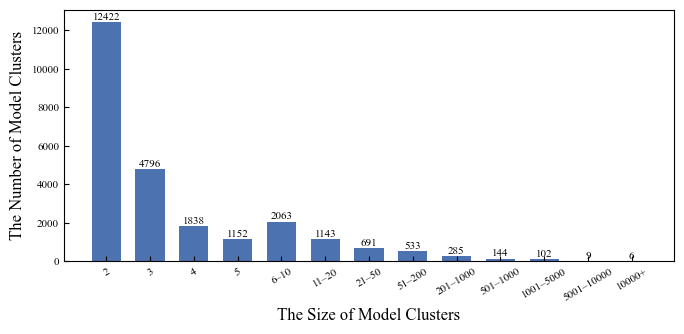

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "mathtext.fontset": "stix",
    "font.size": 12,
    "figure.figsize": (7, 3.5),
    "lines.linewidth": 1,
    "lines.markersize": 4,
    "axes.linewidth": 0.8,
    "axes.titlesize": 10,
    "axes.labelsize": 12,
    "axes.grid": False,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": False,
    "ytick.right": False,
    "legend.fontsize": 12,
    "legend.frameon": False,
    "savefig.dpi": 3600,
    "savefig.bbox": "tight"
})

dis_file = "../../data/root_models_dis_distribution_0625.csv"
df = pd.read_csv(dis_file)
dis_values = (df["DIS"] + 1).astype(int)

bins = [1, 2, 3, 4,5, 10, 20, 50, 200, 500, 1000, 5000, 10000, float('inf')]
labels = [
     "2", "3", "4","5", "6–10", "11–20", "21–50",
    "51–200", "201–1000", "501–1000",
    "1001–5000", "5001–10000", "10000+"
]
bin_categories = pd.cut(dis_values, bins=bins, labels=labels, right=True, include_lowest=True)

bin_counts = bin_categories.value_counts().sort_index()

x_labels = bin_counts.index.tolist()
frequencies = bin_counts.values.tolist()
x_positions = [i * 1.5 for i in range(len(x_labels))] 

plt.figure()
bars = plt.bar(x_positions, frequencies, width=1, color='#4C72B0')

for x, y in zip(x_positions, frequencies):
    plt.text(x, y + 10, str(y), ha='center', va='bottom', fontsize=8)

plt.xticks(ticks=x_positions, labels=x_labels, rotation=30)

plt.xlabel("The Size of Model Clusters")
plt.ylabel("The Number of Model Clusters")
plt.tight_layout()

plt.savefig("cluster_size_distribution.pdf")

#### The distribution of chains num of clusters

Matplotlib created a temporary cache directory at /tmp/matplotlib-ev1fmgnq because the default path (/home/dellr740/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Mean total_chains: 40.06


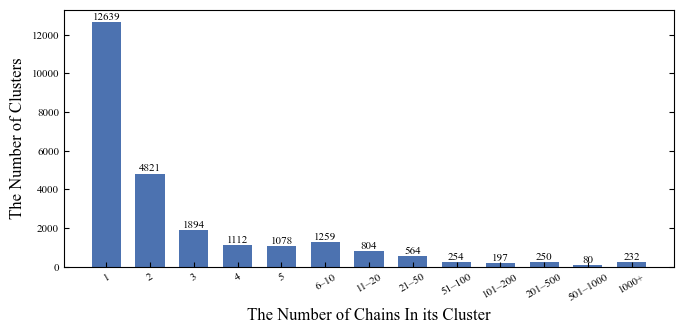

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "mathtext.fontset": "stix",
    "font.size": 12,
    "figure.figsize": (7, 3.5),
    "axes.linewidth": 0.8,
    "axes.labelsize": 12,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": False,
    "ytick.right": True,
    "legend.fontsize": 12,
    "legend.frameon": False,
    "savefig.dpi": 3600,
    "savefig.bbox": "tight"
})

degree_df = pd.read_csv("../../data/model_degree_0625.csv")
root_models = degree_df[(degree_df["In-degree"] == 0) & (degree_df["Out-degree"] > 0)]["Model ID"].str.strip()

depth_df = pd.read_csv("../../data/model_depth_0625.csv")
depth_df["model_id"] = depth_df["model_id"].str.strip()

root_depth_df = depth_df[depth_df["model_id"].isin(root_models)]

bins = [0, 1,2,3,4,6, 11, 21, 51, 101, 201, 501, 1001, float('inf')]
labels = ["1","2","3","4", "5", "6–10", "11–20", "21–50", "51–100", "101–200", "201–500", "501–1000", "1000+"]
binned = pd.cut(root_depth_df["total_chains"], bins=bins, labels=labels, include_lowest=True)
bin_counts = binned.value_counts().sort_index()

x_labels = bin_counts.index.tolist()
frequencies = bin_counts.values.tolist()
x_positions = [i * 1.5 for i in range(len(x_labels))]

plt.figure()
bars = plt.bar(x_positions, frequencies, width=1, color='#4C72B0',)

for x, y in zip(x_positions, frequencies):
    plt.text(x, y + 1, str(y), ha='center', va='bottom', fontsize=8)

plt.xticks(ticks=x_positions, labels=x_labels, rotation=30)
plt.xlabel("The Number of Chains In its Cluster")
plt.ylabel("The Number of Clusters")
plt.tight_layout()

plt.savefig("total_chains_distribution.png")

mean_total_chains = root_depth_df["total_chains"].mean()
print(f"Mean total_chains: {mean_total_chains:.2f}")

#### The dominant relation of model clusters

In [5]:
import pandas as pd
import pickle
from collections import Counter

degree_df = pd.read_csv("../../data/model_degree_0625.csv")
root_models = set(degree_df[(degree_df["In-degree"] == 0) & (degree_df["Out-degree"] > 0)]["Model ID"].str.strip())

with open("../../data/model_clusters_0625.pkl", "rb") as f:
    cluster_dict = pickle.load(f)

filtered_cluster_dict = {root: models for root, models in cluster_dict.items() if root in root_models}
print(len(filtered_cluster_dict))

type_df = pd.read_csv("../../data/batch_all_0625.csv")
type_df["model_id"] = type_df["Model ID"].str.strip()
type_df["type"] = type_df["Type"].str.strip()

model2type = dict(zip(type_df["model_id"], type_df["type"].replace({"adapter": "finetune"})))

results = []
dominant_counter = Counter()

for root, models in filtered_cluster_dict.items():
    type_counter = Counter()
    total = 0

    for m in models:
        t = model2type.get(m)
        if t in {"finetune", "merge", "quantized"}:
            type_counter[t] += 1
            total += 1

    if total == 0:
        continue 

    finetune_pct = type_counter["finetune"] / total
    merge_pct = type_counter["merge"] / total
    quantize_pct = type_counter["quantized"] / total

    dominant_type = type_counter.most_common(1)[0][0]
    dominant_counter[dominant_type] += 1

    results.append({
        "Root Model": root,
        "Cluster Size": len(models),
        "Typed Models": total,
        "Finetune Count": type_counter["finetune"],
        "Merge Count": type_counter["merge"],
        "Quantize Count": type_counter["quantized"],
        "Finetune %": f"{finetune_pct:.2%}",
        "Merge %": f"{merge_pct:.2%}",
        "Quantize %": f"{quantize_pct:.2%}",
        "Dominant Type": dominant_type
    })

output_df = pd.DataFrame(results)
output_df.to_csv("../../data/cluster_type_distribution_0625.csv", index=False)

total_clusters = sum(dominant_counter.values())
print("Dominant Type Statistics:")
for t in ["finetune", "merge", "quantized"]:
    count = dominant_counter[t]
    pct = count / total_clusters if total_clusters else 0
    print(f"{t}: {count} clusters ({pct:.2%})")

single_type = 0
double_type = 0
triple_type = 0

double_type_dominant_counter = Counter()
triple_type_dominant_counter = Counter()

for r in results:
    types_present = sum([
        r["Finetune Count"] > 0,
        r["Merge Count"] > 0,
        r["Quantize Count"] > 0
    ])

    if types_present == 1:
        single_type += 1
    elif types_present == 2:
        double_type += 1
        double_type_dominant_counter[r["Dominant Type"]] += 1
    elif types_present == 3:
        triple_type += 1
        triple_type_dominant_counter[r["Dominant Type"]] += 1

print("\nCluster Type Diversity Statistics:")
print(f"Single-type clusters: {single_type}")
print(f"Double-type clusters: {double_type}")
print(f"Triple-type clusters: {triple_type}")

print("\nDominant types in double-type clusters:")
for t in ["finetune", "merge", "quantized"]:
    count = double_type_dominant_counter[t]
    pct = count / double_type if double_type else 0
    print(f"{t}: {count} clusters ({pct:.2%})")

print("\nDominant types in triple-type clusters:")
for t in ["finetune", "merge", "quantized"]:
    count = triple_type_dominant_counter[t]
    pct = count / triple_type if triple_type else 0
    print(f"{t}: {count} clusters ({pct:.2%})")

25184
Dominant Type Statistics:
finetune: 7199 clusters (28.59%)
merge: 831 clusters (3.30%)
quantized: 17154 clusters (68.11%)

Cluster Type Diversity Statistics:
Single-type clusters: 20639
Double-type clusters: 3371
Triple-type clusters: 1174

Dominant types in double-type clusters:
finetune: 1377 clusters (40.85%)
merge: 270 clusters (8.01%)
quantized: 1724 clusters (51.14%)

Dominant types in triple-type clusters:
finetune: 266 clusters (22.66%)
merge: 112 clusters (9.54%)
quantized: 796 clusters (67.80%)
